Which frames have a water molecule in reactive position(close to the acid/base and oriented to the anomeric carbon)?

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj as md
import itertools

Write the path of the simulation and run just the cell of the simulation you want to analyze

In [2]:
#2_glca_deprot equilibration
dir_name = "/home/oriol/Oriol/GH_A/2_glca_deprot/clas_deprot/"
top_file = dir_name + "3vo0_deprot.prmtop"
file = dir_name + "3vo0_deprot_eq.mdcrd"

In [36]:
#2_glca_deprot production
dir_name = "/home/oriol/Oriol/GH_A/2_glca_deprot/clas_deprot/"
top_file = dir_name + "3vo0_deprot.prmtop"
file = dir_name + "3vo0_deprot_prod.mdcrd"

In [2]:
#16_desperate production
dir_name = "/home/oriol/Oriol/GH_A/16_desperate/"
top_file = dir_name + "3vo0_desp.prmtop"
file = dir_name + "3vo0_desp_prod.nc"

In [ ]:
#21_E45deprot_19 production 60ns
dir_name = "/home/oriol/Oriol/GH_A/21_E45deprot_19/"
top_file = dir_name + "3vo0_deprot45.prmtop"
file = dir_name + "3vo0_deprot45_prod_60ns.nc"

In [2]:
#21_E45deprot_19 production
dir_name = "/home/oriol/Oriol/GH_A/21_E45deprot_19/"
top_file = dir_name + "3vo0_deprot45.prmtop"
file = dir_name + "prod/3vo0_deprot45_prod.nc"

In [102]:
#27_restraint21 production
dir_name = "/home/oriol/Oriol/GH_A/27_restraint21/"
top_file = dir_name + "3vo0_rest.prmtop"
file = dir_name + "prod/3vo0_rest_prod.nc"

This cell loads just the information of the trajectory, not all the coordinates

In [103]:
%%time
traj = md.formats.NetCDFTrajectoryFile(file)
top = md.load_prmtop(top_file)

CPU times: user 728 ms, sys: 112 ms, total: 840 ms
Wall time: 828 ms


In [104]:
print("Frames =",traj.n_frames)

Frames = 8209


Select the atoms to compute the distances

In [105]:
%%time
acid_base = top.select('resid 155 and sidechain and type O') #0-based index, residue 156 [E173]
c_anom = top.select('resname GUG and name C1')               #Anomeric carbon
H_wat = top.select('water and type H')                       #Both Hydrogen atoms of each water molecule
O_wat = top.select('water and type O')                       #Oxygen atoms of each water molecule

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 100 ms


In [106]:
%%time
pair_array_H = np.array(list(itertools.product(H_wat, acid_base))) #Pairs of all the combinations between H_wat list and acid_base list
pair_array_O = np.array(list(itertools.product(O_wat, c_anom)))  

pair_array_c_H = np.array(list(itertools.product(H_wat, c_anom))) 

CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 36.3 ms


### To obtain oriented water molecules

In [107]:
%%time

traj.seek(0, whence=0)
O_cutoff = 0.425 #nm
H_cutoff = 0.2
close_wat = []
oriented_wat = []
dist_H = np.empty((0,pair_array_H.shape[0]))
dist_O = np.empty((0,pair_array_O.shape[0]))
dist_c_H = np.empty((0,pair_array_c_H.shape[0]))

index_time = np.zeros((4,2))   #max allowed waters
residence_count = np.zeros((1,2))
max_residence = 0

for i in range(traj.n_frames):       #loop frames
    index_list=[]
    frame = traj.read_as_traj(top,n_frames=1)
    dist_H = md.compute_distances(frame, pair_array_H)[0]
    dist_O = md.compute_distances(frame, pair_array_O)[0]
    dist_c_H = md.compute_distances(frame, pair_array_c_H)[0]    
    count = 0
    oriented_count = 0
    for j in range(dist_O.shape[0]): #loop waters
        if dist_O[j]>O_cutoff:
            continue
        
        for k in range(4):           #loop Hydrogens (2*2)
            if dist_H[4*j+k]<H_cutoff:
                count+=1
                break
        else:
            break
        index_list.append(O_wat[j])  
    
        if dist_c_H[2*j]<dist_O[j] or dist_c_H[2*j+1]<dist_O[j]:
            break
        oriented_count += 1
    
    for m in range(index_time.shape[0]):
        if index_time[m,0] in index_list:
            index_time[m,1] += 1
            index_list.remove(index_time[m,0])
            if index_time[m,1] > max_residence:
                max_residence = index_time[m,1]
                max_index_residence = index_time[m,0]
        else:
            if index_time[m,0] != -1:
                residence_count[0,0] += 1
                residence_count[0,1] += index_time[m,1]
                index_time[m,1] = 0
                index_time[m,0] = -1
            
    for n in index_list:
        p = 0
        while index_time[p,0] != -1:
            p += 1
        index_time[p,0] = n
        index_time[p,1] = 1            
    
    close_wat.append([frame.time[0],count])
    oriented_wat.append([frame.time[0],oriented_count,traj.tell()])
close_waters=np.asarray(close_wat)
oriented_waters=np.asarray(oriented_wat)
residence_time = residence_count[0,1]/residence_count[0,0]

CPU times: user 1min 26s, sys: 156 ms, total: 1min 26s
Wall time: 1min 26s


In [108]:
print(max_residence)
print(max_index_residence)

22.0
15333.0


In [109]:
#Mean of oriented water molecules over time
mean_ori_wat = np.sum(oriented_waters[:,1])/oriented_waters[:,1].shape[0]
print("Mean of close water molecules over time =", mean_ori_wat)

Mean of close water molecules over time = 0.02509440857595322


In [110]:
frame_ps = 20
print("mean residence time = {} ps  ".format(round(residence_time*frame_ps,3)))
print("maximum residence time = {} ps".format(max_residence*frame_ps))
print("frame = {}ps".format(frame_ps))

mean residence time = 41.227 ps  
maximum residence time = 440.0 ps
frame = 20ps


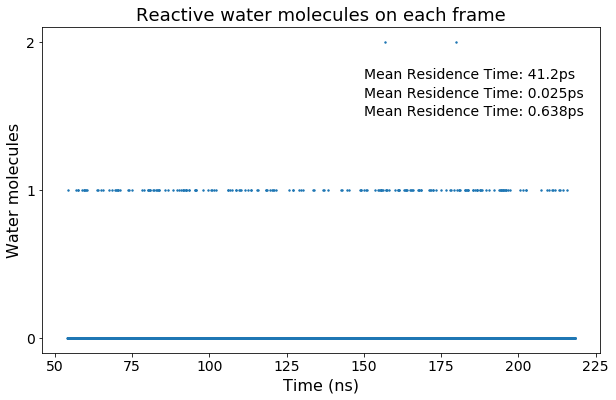

In [111]:
fig1 = plt.figure(figsize=(10,6))
plt.scatter(oriented_waters[:,0]/1000,oriented_waters[:,1], s=2)
# plt.scatter(oriented_waters[:,2],oriented_waters[:,1], s=0.5)
plt.text(150,1.75,"Mean Residence Time: {}ps".format(round(residence_time*frame_ps,1)),fontsize=14)
plt.text(150,1.625,"Mean Residence Time: {}ps".format(round(mean_ori_wat,3)),fontsize=14)
plt.text(150,1.5,"Mean Residence Time: {}ps".format(round(mean_wat,3)),fontsize=14)
# plt.xlabel("Frame", fontsize=16)
plt.xlabel("Time (ns)", fontsize=16)
plt.ylabel("Water molecules", fontsize=16)
plt.title("Reactive water molecules on each frame", fontsize=18)
# plt.savefig("Oriented_waters_4A.png")
plt.xticks(fontsize=14)
plt.yticks([0,1,2],fontsize=14)
plt.show()

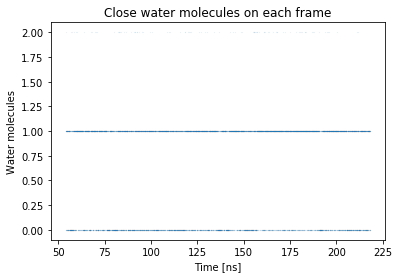

In [112]:
plt.scatter(close_waters[:,0]/1000,close_waters[:,1], s=0.001)
plt.xlabel("Time [ns]")
plt.ylabel("Water molecules")
plt.title("Close water molecules on each frame")
#plt.savefig("Close_waters.png")
plt.show()

In [113]:
#Mean of close water molecules over time
mean_wat = np.sum(close_waters[:,1])/close_waters[:,1].shape[0]
print("Mean of close water molecules over time =", mean_wat)

Mean of close water molecules over time = 0.6712145206480692


In [114]:
mean_list = []
bin_size = 200
bin_size_2 = bin_size/2
for i in range(close_waters[:,1].shape[0] - bin_size):
    mean_list.append(np.sum(close_waters[i:bin_size+i,1])/bin_size)

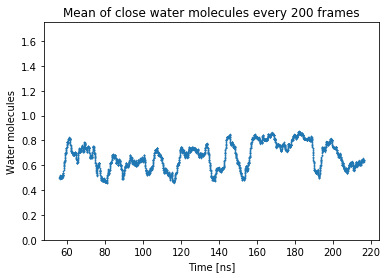

In [115]:
plt.scatter(close_waters[int(bin_size/2):-int(bin_size/2),0]/1000,mean_list, s=0.2)
plt.ylim(0,1.75)
plt.xlabel("Time [ns]")
plt.ylabel("Water molecules")
plt.title("Mean of close water molecules every {} frames".format(bin_size))
#plt.savefig("Mean_close_waters.png")
plt.show()

In [116]:
4+54+218+277

553

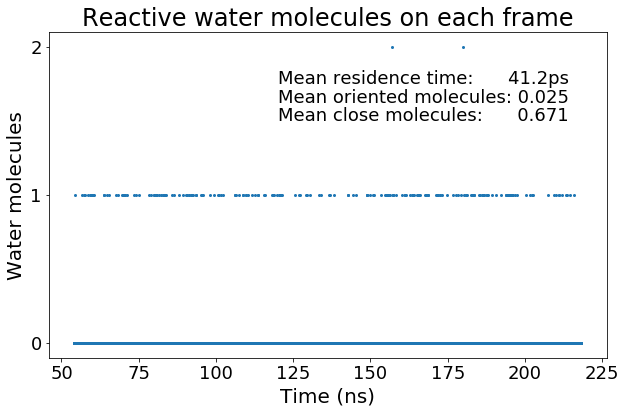

In [131]:
fig1 = plt.figure(figsize=(10,6))
plt.scatter(oriented_waters[:,0]/1000,oriented_waters[:,1], s=4)
# plt.scatter(oriented_waters[:,2],oriented_waters[:,1], s=0.5)
plt.text(120,1.75,"Mean residence time:      {}ps".format(round(residence_time*frame_ps,1)),fontsize=18)
plt.text(120,1.625,"Mean oriented molecules: {}".format(round(mean_ori_wat,3)),fontsize=18)
plt.text(120,1.5,"Mean close molecules:      {}".format(round(mean_wat,3)),fontsize=18)
# plt.xlabel("Frame", fontsize=16)
plt.xlabel("Time (ns)", fontsize=20)
plt.ylabel("Water molecules", fontsize=20)
plt.title("Reactive water molecules on each frame", fontsize=24)
plt.xticks(fontsize=18)
plt.yticks([0,1,2],fontsize=18)
plt.savefig("Oriented_waters_4A.png")
plt.show()

This doesn't calculate the oriented molecules, it's a bit faster

In [ ]:
%%time

traj.seek(0, whence=0) #Go to the first frame
O_cutoff = 0.4 #Angstroms
H_cutoff = 0.2
close_wat = []
dist_H = np.empty((0,pair_array_H.shape[0]))
dist_O = np.empty((0,pair_array_O.shape[0]))

index_time = np.zeros((4,2))   #max allowed waters
residence_count = np.zeros((1,2))
max_residence = 0

for i in range(traj.n_frames):       #loop frames
    index_list=[]
    frame = traj.read_as_traj(top,n_frames=1)  #Load coordinates of current frame
    dist_H = md.compute_distances(frame, pair_array_H)[0]
    dist_O = md.compute_distances(frame, pair_array_O)[0]
    
    count = 0
    for j in range(dist_O.shape[0]): #loop waters
        if dist_O[j]>O_cutoff:
            continue
        for k in range(4):           #loop Hydrogens
            if dist_H[4*j+k]<H_cutoff:
                count+=1                  
                break
        else:      
            break      #If there is no close water, jump to the new frame
        index_list.append(O_wat[j])  #Write down in a list the oxygen index that is 
    
    #To calculate the residence time
    for m in range(index_time.shape[0]):
        if index_time[m,0] in index_list:        #Select the 
            index_time[m,1] += 1
            index_list.remove(index_time[m,0])
            if index_time[m,1] > max_residence:
                max_residence = index_time[m,1]
                max_index_residence = index_time[m,0]
        else:
            if index_time[m,0] != -1:
                residence_count[0,0] += 1
                residence_count[0,1] += index_time[m,1]
                index_time[m,1] = 0
                index_time[m,0] = -1
            
            
    for n in index_list:
        p = 0
        while index_time[p,0] != -1:
            p += 1
        index_time[p,0] = n
        index_time[p,1] = 1            
    
    close_wat.append([frame.time[0],count])
close_waters=np.asarray(close_wat)
residence_time = residence_count[0,1]/residence_count[0,0]